
# 📓 TeleConnect — Training & Evaluation with MLflow

This notebook documents **model training** and **evaluation** for the Telco Churn project.

> **Start MLflow UI first:**
> ```bash
> mlflow ui --backend-store-uri ./mlruns --port 5000
> ```


## 1) Environment & Paths

In [10]:
# === Project root & import path config (ensures imports from src/modules work) ===
from pathlib import Path
import sys, os

def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    for p in [cur, *cur.parents]:
        if (p / "mlruns").exists():   # anchor folder present at project root
            return p
    return cur  # fallback: current dir

NB_DIR = Path.cwd()
PROJECT_ROOT = find_project_root(NB_DIR)
print("Notebook dir:", NB_DIR)
print("Project root:", PROJECT_ROOT)

MODULES_DIR = PROJECT_ROOT / "src" / "modules"
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))
print("Modules path added:", MODULES_DIR)

# Common settings
PROC_DIR = str(PROJECT_ROOT / "data" / "processed")
MLFLOW_URI = "http://localhost:5000"
EXPERIMENT_NAME = "telco-churn"

print("PROC_DIR:", PROC_DIR)
print("MLFLOW_URI:", MLFLOW_URI)
print("EXPERIMENT:", EXPERIMENT_NAME)


Notebook dir: /home/buntu/uni/MLOPS/project/src/notebooks
Project root: /home/buntu/uni/MLOPS/project
Modules path added: /home/buntu/uni/MLOPS/project/src/modules
PROC_DIR: /home/buntu/uni/MLOPS/project/data/processed
MLFLOW_URI: http://localhost:5000
EXPERIMENT: telco-churn


## 2) Quick sanity check of processed data

In [11]:

import pandas as pd
for p in [os.path.join(PROC_DIR, "train.csv"),
          os.path.join(PROC_DIR, "val.csv"),
          os.path.join(PROC_DIR, "test.csv")]:
    print(p, "exists:", os.path.exists(p))


/home/buntu/uni/MLOPS/project/data/processed/train.csv exists: True
/home/buntu/uni/MLOPS/project/data/processed/val.csv exists: True
/home/buntu/uni/MLOPS/project/data/processed/test.csv exists: True


In [12]:
from pathlib import Path
import sys

NB_DIR = Path.cwd()                 # this is src/notebooks
MODULES_DIR = NB_DIR.parent / "modules"  # -> src/modules
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))
print("Using modules dir:", MODULES_DIR)

import modelBaselineMlflow as train_mod  # <- no 'src.' prefix here


Using modules dir: /home/buntu/uni/MLOPS/project/src/modules


## 3) Train models with MLflow uses modelBaseline from modules

In [13]:
import sys
argv_bak = sys.argv
sys.argv = ["modelBaselineMlflow.py",
            "--proc_dir", PROC_DIR,
            "--mlflow_uri", MLFLOW_URI,
            "--experiment", EXPERIMENT_NAME]
try:
    train_mod.main()
finally:
    sys.argv = argv_bak


2025/11/03 20:56:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 20:56:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run logreg at: http://localhost:5000/#/experiments/614247080687113769/runs/74d19fcfd5cf4844be139abdf6a0827d
🧪 View experiment at: http://localhost:5000/#/experiments/614247080687113769


2025/11/03 20:57:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 20:57:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run random_forest at: http://localhost:5000/#/experiments/614247080687113769/runs/cc2911de6e1249c7be9cc218db4fbfd7
🧪 View experiment at: http://localhost:5000/#/experiments/614247080687113769
🏃 View run xgboost_skipped at: http://localhost:5000/#/experiments/614247080687113769/runs/b9e16a3088f84bd7a9beeed57e8d045b
🧪 View experiment at: http://localhost:5000/#/experiments/614247080687113769
🏃 View run lightgbm_skipped at: http://localhost:5000/#/experiments/614247080687113769/runs/808e749478d34229a7bb87a6248725e3
🧪 View experiment at: http://localhost:5000/#/experiments/614247080687113769


2025/11/03 20:57:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 20:57:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run final_test_eval at: http://localhost:5000/#/experiments/614247080687113769/runs/b47645524cb3426b9ca837af7de2bda1
🧪 View experiment at: http://localhost:5000/#/experiments/614247080687113769
[OK] Entrenamiento y evaluación registrados en MLflow.


## 4) Load best run and print model name

In [19]:
# === Robust best-run selection + model loading using module function ===
import mlflow
from mlflow.tracking import MlflowClient
import sys
from pathlib import Path

# Import modelEvaluation module to use its load_model_from_run function
MODULES_DIR = Path(PROJECT_ROOT) / "src" / "modules"
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))

import modelEvaluation as eval_mod

mlflow.set_tracking_uri(MLFLOW_URI)
client = MlflowClient()

# Get experiment and best run by val_f1
exp = client.get_experiment_by_name(EXPERIMENT_NAME)
assert exp is not None, f"Experiment '{EXPERIMENT_NAME}' not found at {MLFLOW_URI}."
exp_id = exp.experiment_id

runs = client.search_runs([exp_id], order_by=["metrics.val_f1 DESC"], max_results=1)
assert runs, "No runs found. Train a model first."
best = runs[0]
best_run_id = best.info.run_id
print("Best run by val_f1:", best_run_id)

# Use the module's load_model_from_run function (has robust fallback logic)
# If best run is a TRAIN run it has 'model'; if it's 'final_test_eval', it has 'final_model'
try:
    model = eval_mod.load_model_from_run(best_run_id, model_stage="model")
    print("[OK] Model loaded successfully (from 'model' stage)")
except Exception as e:
    # Try final_model if model fails
    print(f"[INFO] Trying 'final_model' stage: {str(e)[:100]}")
    model = eval_mod.load_model_from_run(best_run_id, model_stage="final_model")
    print("[OK] Model loaded successfully (from 'final_model' stage)")

# Print estimator class if it's a pipeline with 'clf' step
try:
    if hasattr(model, "named_steps") and "clf" in model.named_steps:
        print("Estimator:", model.named_steps["clf"].__class__.__name__)
    else:
        print("Loaded object:", type(model).__name__)
except Exception as e:
    print("Introspection error:", e)

Best run by val_f1: 74d19fcfd5cf4844be139abdf6a0827d


[OK] Model loaded successfully (from 'model' stage)
Estimator: LogisticRegression


## 5) Full evaluation (logs metrics & artifacts to MLflow)

In [22]:
# Evaluate and log everything (metrics + plots) to MLflow

import sys
from pathlib import Path
import importlib

# 1) Make sure we import from src/modules using the root we computed earlier
MODULES_DIR = Path(PROJECT_ROOT) / "src" / "modules"
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))

# Reload the module to get the latest code with --skip_shap argument
import modelEvaluation as eval_mod
importlib.reload(eval_mod)  # This reloads the module with the latest code

# 2) Call the module's main() by simulating CLI args
argv_bak = sys.argv
sys.argv = [
    "modelEvaluation.py",
    "--proc_dir", PROC_DIR,
    "--mlflow_uri", MLFLOW_URI,
    "--experiment", EXPERIMENT_NAME,

    # 👇 ensure we evaluate the exact run we just selected
    "--run_id", best_run_id,

    # the best run you loaded is a training run -> artifact subdir is 'model'
    "--model_stage", "model",

    # business + CV knobs
    "--n_splits", "5",
    "--avg_monthly_revenue", "850",
    "--intervention_cost", "25",
    "--intervention_rate", "0.30",
    "--retention_success_rate", "0.25",
    
    # 👇 Skip SHAP to avoid errors (temporary)
    "--skip_shap",
]
try:
    eval_mod.main()
finally:
    sys.argv = argv_bak

[INFO] SHAP analysis skipped (--skip_shap flag)
== Test metrics ==
accuracy: 0.8043
precision: 0.6455
recall: 0.5276
f1: 0.5806
roc_auc: 0.7963
== Business impact (net Q) == 67575.0
🏃 View run evaluation_module at: http://localhost:5000/#/experiments/614247080687113769/runs/37d80d09a6c04f039363dfbe1f9b8106
🧪 View experiment at: http://localhost:5000/#/experiments/614247080687113769
[OK] Evaluación completa registrada en MLflow.


Evaluation run_id: 37d80d09a6c04f039363dfbe1f9b8106


,value
test_precision,0.645492
test_f1,0.580645
test_recall,0.527638
temporal_cv_f1_mean,0.284476
temporal_cv_roc_auc_mean,0.848091
test_accuracy,0.804301
bi_true_churn_in_topk,403.000000
test_roc_auc,0.796331
bi_net_impact_q,67575.000000
bi_topk,697.000000


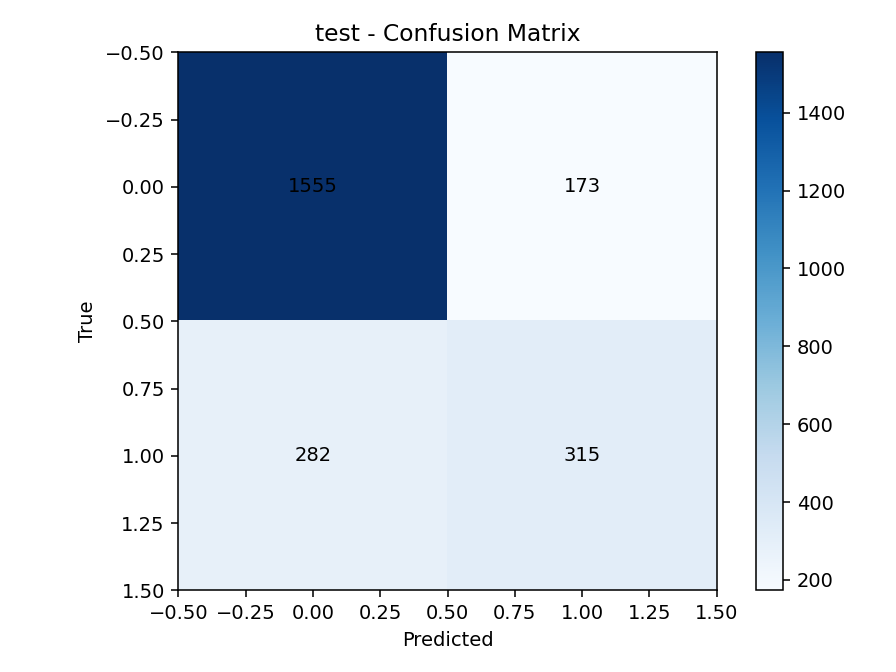

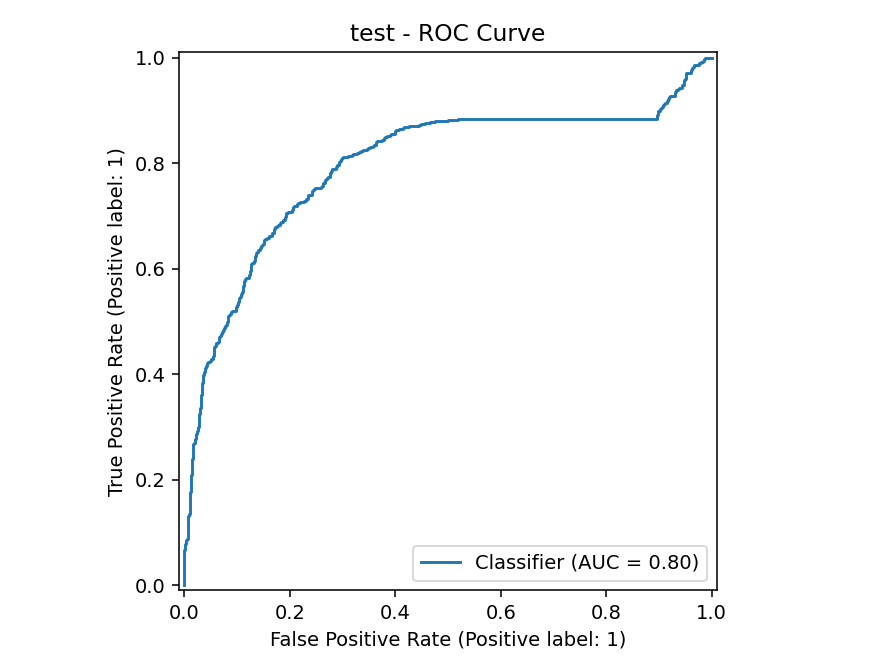

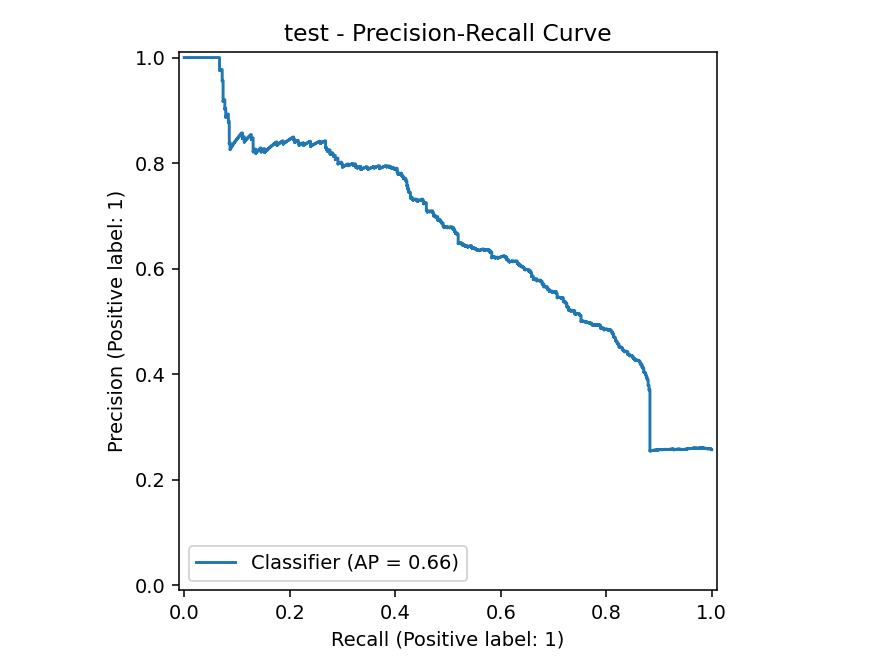


test_metrics.json:
{
  "accuracy": 0.8043010752688172,
  "precision": 0.6454918032786885,
  "recall": 0.5276381909547738,
  "f1": 0.5806451612903226,
  "roc_auc": 0.7963311930020474
}

business_impact.json:
{
  "n_samples": 2325,
  "k_targeted": 697,
  "top_rate": 0.3,
  "true_churn_in_topk": 403,
  "retention_success_rate": 0.25,
  "retained_customers": 100,
  "avg_monthly_revenue": 850.0,
  "intervention_cost": 25.0,
  "gross_benefit_q": 85000.0,
  "intervention_cost_total_q": 17425.0,
  "net_impact_q": 67575.0
}


In [23]:
# 📊 Fetch the latest "evaluation_module" run and display key metrics + plots in the notebook
from mlflow.tracking import MlflowClient
from pathlib import Path
import json, pandas as pd
from IPython.display import display, Image

client = MlflowClient()
exp = client.get_experiment_by_name(EXPERIMENT_NAME)
assert exp is not None, f"Experiment '{EXPERIMENT_NAME}' not found."

# get most recent evaluation run
runs = client.search_runs(
    [exp.experiment_id],
    filter_string="tags.mlflow.runName = 'evaluation_module'",
    order_by=["attributes.start_time DESC"],
    max_results=1
)
assert runs, "No evaluation_module run found. Run the evaluation cell first."
eval_run = runs[0]
eval_run_id = eval_run.info.run_id
print("Evaluation run_id:", eval_run_id)

# 1) Collect metrics directly from MLflow
metrics = eval_run.data.metrics  # a dict with all logged metrics
# pick the most relevant to show
pick = {k:v for k,v in metrics.items() if k.startswith("test_") or k.startswith("temporal_cv_") or k.startswith("bi_")}
df_metrics = pd.DataFrame([pick]).T
df_metrics.columns = ["value"]
display(df_metrics)

# 2) Download + show artifacts (confusion matrix, ROC, PR, metrics.json, business_impact.json)
dst = Path("src/notebooks/mlruns_artifacts") / eval_run_id
dst.mkdir(parents=True, exist_ok=True)

# helper to download and maybe display an image
def get_artifact(path_rel, show_image=False):
    try:
        local_path = client.download_artifacts(eval_run_id, path_rel, dst_path=str(dst))
        if show_image:
            display(Image(filename=local_path))
        return local_path
    except Exception as e:
        print(f"[skip] {path_rel}: {e}")

# images
get_artifact("test_confusion_matrix.png", show_image=True)
get_artifact("test_roc.png", show_image=True)
get_artifact("test_pr.png", show_image=True)

# JSONs
test_metrics_json = get_artifact("test_metrics.json", show_image=False)
bi_json = get_artifact("business_impact.json", show_image=False)

# pretty print JSONs if present
for p in [test_metrics_json, bi_json]:
    if p:
        with open(p) as f:
            print(f"\n{Path(p).name}:")
            print(json.dumps(json.load(f), indent=2))
